In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

In [3]:
LOGGING_FILE = 'bookkeeping.json'
df = pd.read_json(LOGGING_FILE)
df

,MSE,R2,RMSE,batch_size,epochs,hidden_size,intercept,lr,name,repeat,search_method,slope,test_batch_size,validation_loss,weight_decay
0,0.065516,1.950000e-08,0.255960,1000,100,32,1.270300e-06,1.000000e-02,loudly-allowing-bobcat-bUuR,2,gird,0.021399,100,0.065516,0.992091
1,0.065517,1.080000e-08,0.255963,1000,100,32,-2.747000e-07,1.000000e-02,honestly-hardy-tarpon-seUJ,2,gird,-0.013235,100,0.065517,0.976462
2,0.065515,6.040000e-08,0.255959,1000,100,32,-2.956300e-06,1.000000e-02,endlessly-nearby-marten-PpfM,2,gird,0.043127,100,0.065515,1.000000
3,0.065515,6.840000e-08,0.255959,1000,100,32,-2.340200e-06,1.000000e-02,partially-innocent-cockatoo-HQch,2,gird,-0.046546,100,0.065515,0.984246
4,0.065518,5.690000e-08,0.255964,1000,100,32,4.631000e-07,1.000000e-02,awfully-dynamic-opossum-t1dZ,2,gird,-0.029220,100,0.065518,0.961078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.686109,2.600000e-08,0.828317,1000,100,32,2.684200e-06,1.000000e-08,willingly-hardy-camel-cM2u,2,gird,-0.000052,100,0.686109,0.800660
884,0.390519,6.360000e-08,0.624915,1000,100,32,3.125100e-06,1.000000e-08,hideously-wise-labrador-uXA6,2,gird,-0.000113,100,0.390519,0.807043
885,0.400075,2.649000e-07,0.632515,1000,100,32,-9.964200e-06,1.000000e-08,actually-stable-chipmunk-ts0Z,2,gird,0.000228,100,0.400075,0.819961
886,0.364277,2.000000e-10,0.603554,1000,100,32,3.960000e-08,1.000000e-08,entirely-good-killdeer-fYDI,2,gird,-0.000006,100,0.364277,0.826497


In [4]:
plt.close('all')
x = np.log(df['lr'].values)
y = np.log(df['weight_decay'].values)
z = df['RMSE'].values
ax = plt.axes(projection='3d') 
ax.plot_trisurf(x, y, z,
                cmap='viridis', edgecolor='none');

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

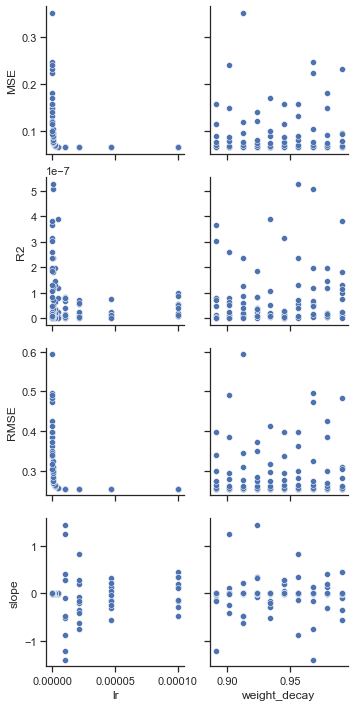

In [10]:
sns.pairplot(df,
            x_vars=['lr', 'weight_decay'],
            y_vars=['MSE', 'R2', 'RMSE', 'slope'])

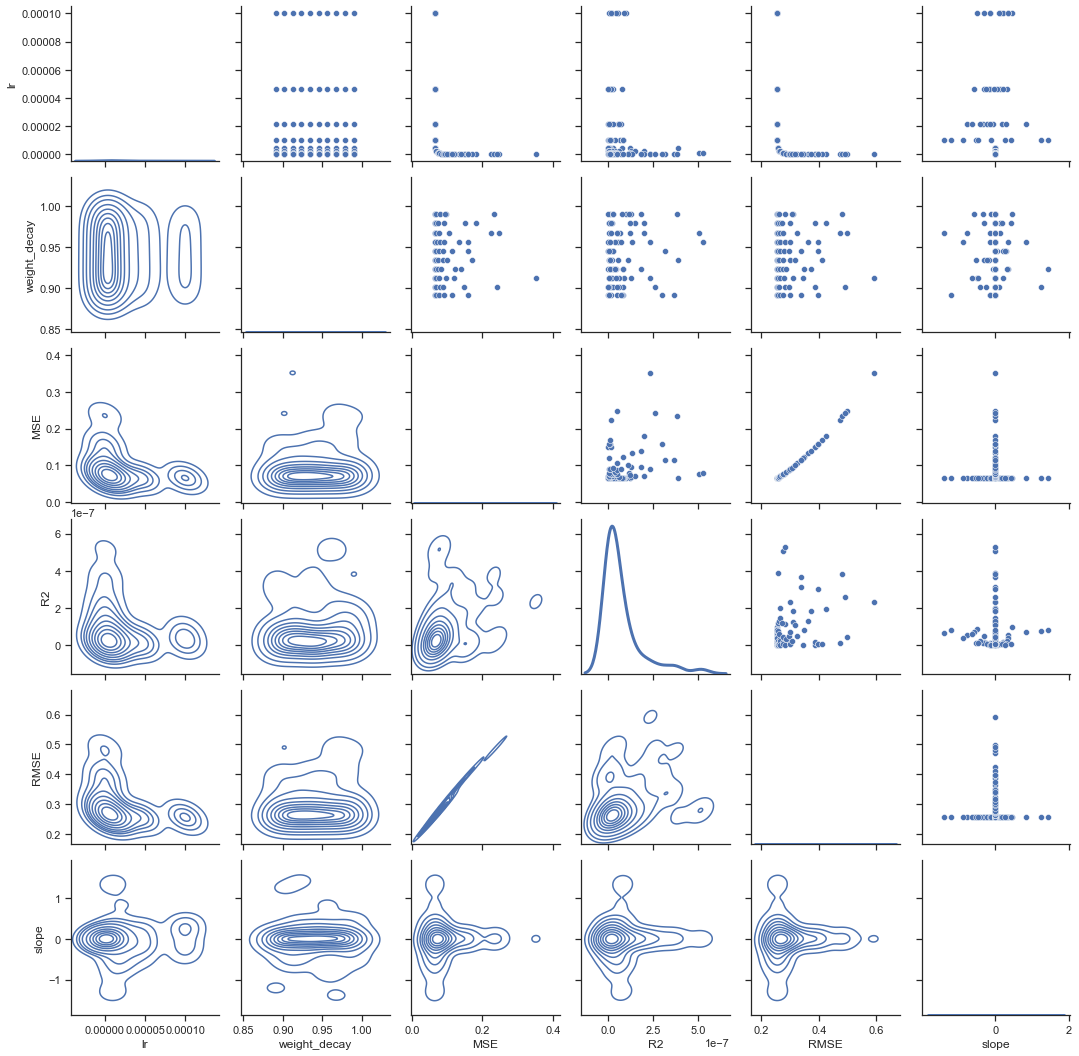

In [12]:
g = sns.PairGrid(df,
            x_vars=['lr', 'weight_decay','MSE', 'R2', 'RMSE', 'slope'],
            y_vars=['lr', 'weight_decay','MSE', 'R2', 'RMSE', 'slope'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

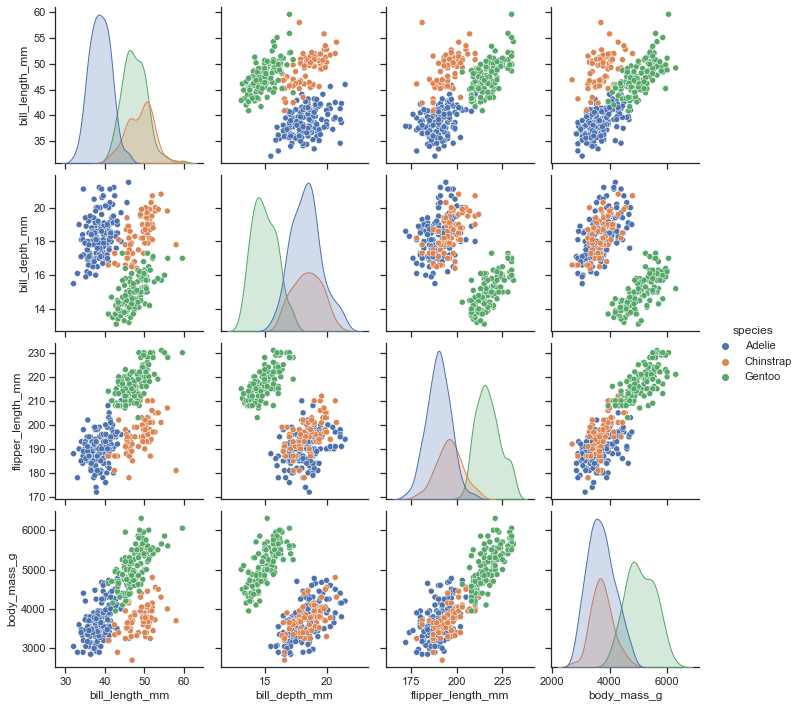

In [1]:

sns.set_theme(style="ticks")

df = sns.load_dataset("penguins")
sns.pairplot(df, hue="species")